In [2]:
import os
import numpy as np
import torch
import cv2
import supervision as sv

from mobile_sam import sam_model_registry, SamPredictor

from entities import Point, Box


/Users/tarasbohdan/Desktop/projects/idea-contest-2023/ideation-api/venv/lib/python3.8/site-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/tarasbohdan/Desktop/projects/idea-contest-2023/ideation-api/venv/lib/python3.8/site-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/tarasbohdan/Desktop/projects/idea-contest-2023/ideation-api/venv/lib/python3.8/site-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with mo

In [3]:
import os

current_directory = os.getcwd()

parent_directory = os.path.dirname(current_directory)

print("Current Directory:", current_directory)
print("Parent Directory:", parent_directory)

Current Directory: /Users/tarasbohdan/Desktop/projects/idea-contest-2023/ideation-api/notebooks
Parent Directory: /Users/tarasbohdan/Desktop/projects/idea-contest-2023/ideation-api


In [4]:
HOME = parent_directory
check_point_file = "mobile_sam.pt"
CHECKPOINT_PATH = os.path.join(HOME, "weights", f"{check_point_file}")
device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_TYPE = "vit_t"

mobile_sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=device)

predictor = SamPredictor(mobile_sam)

In [13]:
def process_image_with_model(image_path, default_box: Box, predictor: SamPredictor):
    image_bgr = cv2.imread(image_path)

    if image_bgr is None:
        print("Error: Image not found or unable to read.")
        return

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    height, width = image_bgr.shape[:2]
    print(f"Image size: Width = {width}, Height = {height}")

    predictor.set_image(image_rgb)
    print('Predicting')

    # scale_factor: float = width / 600 # FIXME receive this parameter from frontend
    scale_factor: float = 1.0

    # TODO load file with default box drawn to check if we get the correct box from the file
    box_coords = np.array([
        default_box['x'] * scale_factor,
        default_box['y'] * scale_factor,
        (default_box['x'] + default_box['width']) * scale_factor,
        (default_box['y'] + default_box['height']) * scale_factor
    ])

    masks, _, _ = predictor.predict(
        box=box_coords,
        multimask_output=False
    )
    print('Masks Generated')
    box_annotator = sv.BoxAnnotator(color=sv.Color.red())
    mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=masks),
        mask=masks
    )
    detections = detections[detections.area == np.max(detections.area)]

    source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
    cv2.imwrite(os.path.join(os.getcwd(), "data", "source_image.jpeg"), source_image)

    segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
    output_path = os.path.join(parent_directory, "data", "annotated_image_2.jpeg")
    cv2.imwrite(output_path, segmented_image)

    return output_path

In [10]:
default_box= {'x': 50, 'y': 50, 'width': 330, 'height': 350, 'label': ''}

image_bgr = cv2.imread(f'{parent_directory}/data/dancing.jpg')

if image_bgr is None:
    print("Error: Image not found or unable to read.")
    exit()

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
box_annotator = sv.BoxAnnotator(color=sv.Color.red())

# Annotate the image
annotated_image = box_annotator.annotate(
    scene=image_bgr.copy(),
    detections=sv.Detections(xyxy=np.array([
        default_box['x'],
        default_box['y'],
        default_box['x'] + default_box['width'],
        default_box['y'] + default_box['height']
    ]).reshape(1, 4))
)

# Save the annotated image
cv2.imwrite(os.path.join(parent_directory, "data", "annotated_image.jpeg"), annotated_image)


True

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [45]:
import os

In [14]:
segmented_image_path = process_image_with_model(f'{parent_directory}/data/dancing.jpg', default_box, predictor)


Image size: Width = 444, Height = 444
Predicting
Masks Generated


In [35]:
image_bgr = cv2.imread(f'{parent_directory}/data/dancing.jpg')

if image_bgr is None:
    print("Error: Image not found or unable to read.")
    exit()

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

height, width = image_bgr.shape[:2]
print(f"Image size: Width = {width}, Height = {height}")

predictor.set_image(image_rgb)
print('Predicting')

# scale_factor: float = width / 600 # FIXME receive this parameter from frontend
scale_factor: float = 1.0

# TODO load file with default box drawn to check if we get the correct box from the file
box_coords = np.array([
    default_box['x'] * scale_factor,
    default_box['y'] * scale_factor,
    (default_box['x'] + default_box['width']) * scale_factor,
    (default_box['y'] + default_box['height']) * scale_factor
])

masks, _, _ = predictor.predict(
    box=box_coords,
    multimask_output=False
)
print('Masks Generated')
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
cv2.imwrite(os.path.join(parent_directory, "data", "source_image.jpeg"), source_image)

segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
output_path = os.path.join(parent_directory, "data", "annotated_image_2.jpeg")
cv2.imwrite(output_path, segmented_image)

Image size: Width = 444, Height = 444
Predicting
Masks Generated


True

In [38]:
detections.mask[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [25]:
true_count = np.sum(masks)

# Get the coordinates of True values
true_coordinates = np.argwhere(masks)

print("Number of True values in masks:", true_count)
print("Coordinates of True values in masks:", true_coordinates.shape)

Number of True values in masks: 25106
Coordinates of True values in masks: (25106, 3)


In [21]:
# Masks number of values that equals to True
print(f"Number of masks: {len(masks)}")

# Number of pixels in each mask
print(f"Number of pixels in each mask: {[np.sum(mask) for mask in masks]}")

masks = masks.astype(np.uint8)

print(masks)

# Number of True pixels in each mask
print(f"Number of True pixels in each mask: {[np.sum(mask) for mask in masks]}")

Number of masks: 1
Number of pixels in each mask: [25106]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
Number of True pixels in each mask: [25106]


In [46]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader(f"{parent_directory}/data/picasso.jpg")
content_img = image_loader(f"{parent_directory}/data/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

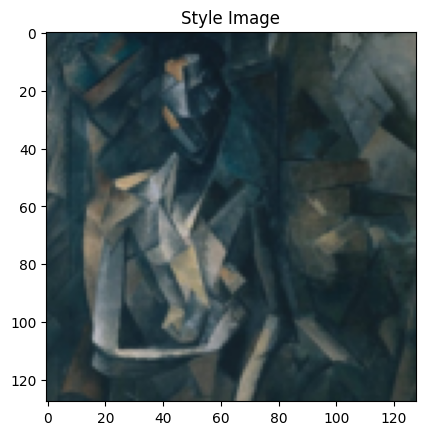

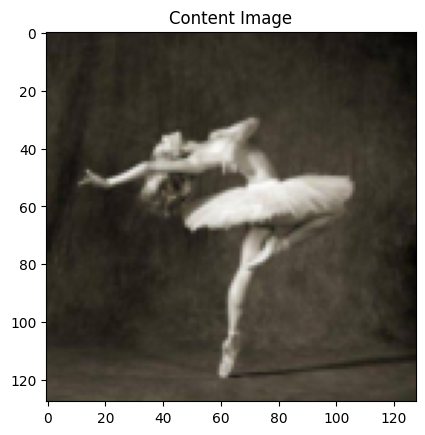

In [47]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [48]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [49]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [50]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [51]:
!pip install --upgrade certifi

Python(1343) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


You should consider upgrading via the '/Users/tarasbohdan/Desktop/projects/idea-contest-2023/ideation-api/venv/bin/python3.8 -m pip install --upgrade pip' command.


In [52]:
import os
import certifi

os.environ['SSL_CERT_FILE'] = certifi.where()

In [53]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [54]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [55]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

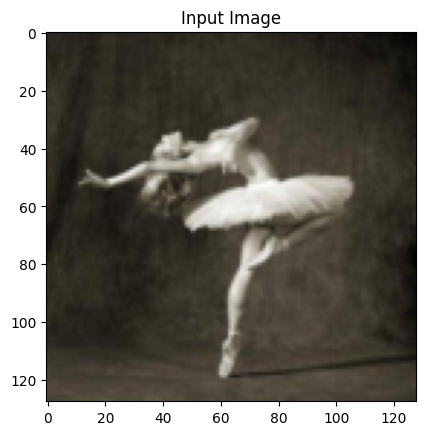

In [56]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# ::
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [57]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [58]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..


/Users/tarasbohdan/Desktop/projects/idea-contest-2023/ideation-api/venv/lib/python3.8/site-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing..
run [50]:
Style Loss : 24.817640 Content Loss: 9.843668

run [100]:
Style Loss : 6.973824 Content Loss: 8.730038

run [150]:
Style Loss : 3.722337 Content Loss: 7.978809

run [200]:
Style Loss : 2.731739 Content Loss: 7.471065

run [250]:
Style Loss : 2.246134 Content Loss: 7.149652

run [300]:
Style Loss : 1.972694 Content Loss: 6.937741



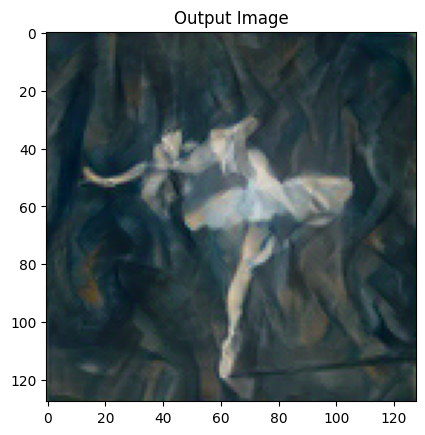

In [59]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [60]:
mask = detections.mask[0]
mask = mask.astype(bool)

# Combine the images
combined_image = np.where(mask[..., None], output, content_img)

SystemError: <built-in function where> returned NULL without setting an error

In [62]:
print(content_img.shape)
print(output.shape)
print(mask.shape)


torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
(444, 444)


In [64]:
import torch
import numpy as np
import cv2

# Convert PyTorch tensors to numpy arrays and remove the batch dimension
content_img_np = content_img.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
styled_img_np = output.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

# Normalize the images to 0-255 if necessary
content_img_np = (content_img_np - content_img_np.min()) / (content_img_np.max() - content_img_np.min()) * 255
styled_img_np = (styled_img_np - styled_img_np.min()) / (styled_img_np.max() - styled_img_np.min()) * 255

# Convert images to uint8
content_img_np = content_img_np.astype(np.uint8)
styled_img_np = styled_img_np.astype(np.uint8)

# Check if the mask is empty
if mask.size == 0:
    print("Error: Mask is empty")
    # Handle the empty mask case appropriately
    # ...

# Convert the mask to a data type suitable for OpenCV, if necessary
if mask.dtype != np.uint8:
    mask = mask.astype(np.uint8) * 255  # Convert boolean mask to uint8

# Resize mask to 128x128
mask_resized = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_AREA)

# Convert to boolean again after resizing
mask_resized = mask_resized.astype(bool)

# Add an extra dimension to mask
mask_3d = mask_resized[..., None]

# Combine the images
combined_image = np.where(mask_3d, styled_img_np, content_img_np)


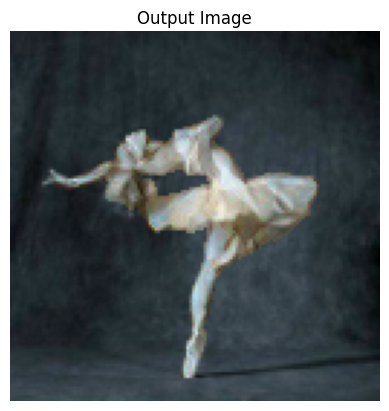

In [66]:
combined_image_rgb = cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(combined_image_rgb)  # If already in RGB. If in BGR, use combined_image_rgb
plt.title('Output Image')
plt.axis('off')  # To turn off the axis
plt.show()

In [67]:
cv2.imwrite(f'{parent_directory}/data/output.jpg', combined_image_rgb)

True